In [1]:
#basic imports
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    """Takes in single scalar value, wraps it and track it"""
    def __init__(self, data, _children=(), _op='', label=''):
        self.label = label
        #derivative of output(for example loss function) with respect to this value 
        self.grad = 0.0
        self.data= data
        self._prev = set(_children)
        self._op = _op 
        self._backward = lambda: None
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
                self.grad += 1.0 * out.grad
                other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self.__add__(other)
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supportinh int/float powers for now'
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self.__mul__(other)

    def __truediv__(self, other):
        return self * other**-1
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def backward(self):
        #topological sort of a computation graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        #_backward() applied to every node in the graph
        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid=str(id(n))
        #for any value in the graph create rectangular node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
           #if value is a result of operation create op node for it
           dot.node(name = uid + n._op, label = n._op)
           #and connect this node to it
           dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


In [4]:
import torch 
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((xi*wi for wi, xi in zip(self.w, x)), self.b) #dot product of weights and data + bias
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs ) == 1 else outs
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    """Multilayer perceptron"""
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [6]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.7355068873548051)

In [7]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [11]:
loss = 0
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.14533678577659787
1 0.12888340685797084
2 0.11542904398858563
3 0.10426124469350787
4 0.0948697130551244
5 0.0868809869516832
6 0.0800164445201191
7 0.07406461718300936
8 0.06886251010828778
9 0.06428273304202652
10 0.06022446360312395
11 0.056606990549562294
12 0.053365026654504925
13 0.05044525638844925
14 0.0478037589454066
15 0.04540406089010887
16 0.04321564780978309
17 0.04121281477751997
18 0.03937376981110845
19 0.037679928285859504


In [12]:
ypred

[Value(data=0.924232877008884),
 Value(data=-0.8897737449120505),
 Value(data=-0.9158847104011723),
 Value(data=0.8872433500652833)]

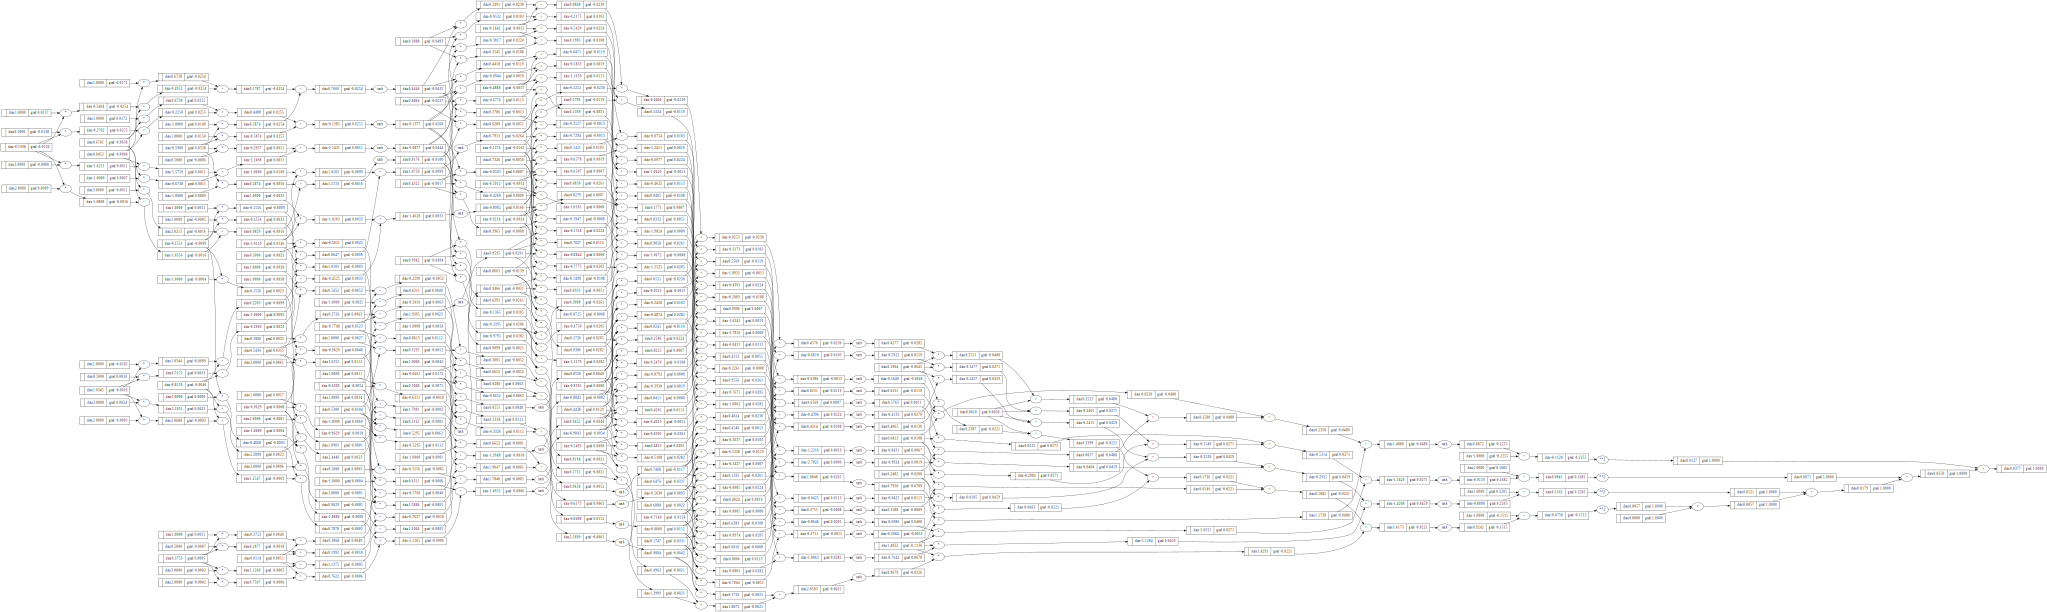

In [14]:
draw_dot(loss)